In [13]:
import numpy as np
import matplotlib.pyplot as plt
import random
from copy import deepcopy


def mul_matrix_by_vector(matrix, vector):
    assert len(matrix[0]) == len(vector)
    return np.array([sum(matrix[i][j] * vector[j] for j in range(len(vector))) for i in range(len(matrix))])

def mul_matrix(matrix1, matrix2):
    assert len(matrix1[0]) == len(matrix2)
    return np.array([
        [sum(matrix1[i][k] * matrix2[k][j] for k in range(len(matrix2[0])))
         for j in range(len(matrix2[0]))]
        for i in range(len(matrix1))
    ])

def scalar(vector1, vector2):
    assert len(vector1) == len(vector2)
    return sum(x * y for x, y in zip(vector1, vector2))

def norm(vector):
    return np.sqrt(sum(x**2 for x in vector))

def generate_sim_matrix(n=4, a=0, b=5, diag = False):
    A = np.zeros(shape=(n, n))
    for i in range(n):
        for j in range(i, n):
            value = random.uniform(a, b)
            A[i][j] = value
            A[j][i] = value
    if diag is not None:
        for i in range(len(A)):
            sg = 1 if A[i][i] > 0 else -1
            A[i][i] = abs(A[i][i])
            A[i][i] += sg * diag * sum(abs(A[i][j]) for j in range(n) if j != i)
    return A


def gerchgorin_intervals(A):
    intervals = []
    for i in range(len(A)):
        center = A[i][i]
        radius = sum(abs(A[i][j]) for j in range(len(A)) if j != i)
        intervals.append([center - radius, center + radius])

    intervals.sort(key=lambda x:x[0])
    merged = [intervals[0]]
    for i in range(1, len(intervals)):
        current_interval = intervals[i]
        previous_interval = merged[-1]
        if current_interval[0] <= previous_interval[1]:
            merged[-1] = [previous_interval[0], max(previous_interval[1], current_interval[1])]
        else:
            merged.append(current_interval)

    return merged

def binary_search_roots(intervals, f, delta=1e-3):
    lambdas = []
    for interval in intervals:
        left = interval[0]
        right = interval[1]
        f_left = f(left)
        assert f_left * f(right) < 0
        x = (left + right) / 2
        f_x = f(x)
        while abs(f_x) > delta:
            if f_left * f_x < 0:
                right = x
            else:
                left = x
                f_left = f(left)
            x = (left + right) / 2
            if x == left or x == right:
                break
            f_x = f(x)
        lambdas.append(x)
    return lambdas


def binary_search_intervals(intervals, f, delta=0.0001):
    search_intervals = []
    for interval in intervals:
        left = interval[0]
        right = interval[1]
        delta_x = left + delta
        while delta_x <= right:
            f_left = f(left)
            f_delta = f(delta_x)
            if f_left * f_delta <= 0:
                search_intervals.append([left, delta_x])
                left = delta_x
                delta_x = left + delta
            else:
                delta_x += delta
    return search_intervals

def check_gerchgorin(intervals, eigs):
    for eig in eigs:
        interval_found = False
        for interval in intervals:
            if interval[0] <= eig <= interval[1]:
                interval_found = True
                break
        if not interval_found:
            return False
    return True

def krylov(A):
    n = len(A)
    y = np.zeros(n)
    y[0] = 1
    Y = [y]
    for i in range(n - 1):
        y = mul_matrix_by_vector(A, y)
        Y.append(y)
    b = mul_matrix_by_vector(A, y)
    Y = np.array(list(reversed(Y)))
    P = Y.T
    coefs = np.linalg.solve(P, b)
    return coefs, Y

def is_sym_matrix(A):
    for i in range(len(A)):
        for j in range(i, len(A)):
            if A[i][j] != A[j][i]:
                return False
    return True

def eig(A):
    assert len(A) == len(A[0])
    assert is_sym_matrix(A)
    n = len(A)
    intervals = gerchgorin_intervals(A)
    coefs, B = krylov(A)
    coefs = -1 * coefs
    f = lambda x: np.polyval(np.hstack((np.array(1), coefs)), x)
    search_intervals = binary_search_intervals(intervals, f)
    assert len(search_intervals) == n
    eigs = binary_search_roots(search_intervals, f)
    assert check_gerchgorin(intervals, eigs)
    return np.array(eigs)

In [14]:
def single_parameter(A, b, tao, spectre, delta=1e-7):
    n = len(A)
    P = np.eye(n) - tao * A
    g = tao * b

    x_gauss = np.linalg.solve(A, b)
    Mu = np.array([1 - tao * spectre[i] for i in range(n)])
    assert np.max(np.abs(Mu)) < 1
    k = 0
    x_prev = np.zeros(shape=(n, ))
    difference = np.array([1] * n)
    x_k = None
    while norm(difference) > delta:
        x_k = mul_matrix_by_vector(P, x_prev) + g
        difference = x_k - x_prev
        r = x_k - x_gauss
        #if (norm(r) ** 2) > max(Mu[i] ** 2 for i in range(n)) * norm(x_prev - x_gauss) ** 2:
        #    print("One", norm(r) ** 2)
        #    print("Two", max(Mu[i] ** 2 for i in range(n)) * norm(x_prev - x_gauss) ** 2)
        if np.round(norm(r) ** 2, 7) > np.round(max(Mu[i] ** 2 for i in range(n)) * norm(x_prev - x_gauss) ** 2, 7):
            print(f"Proverka is not okay: tao - {tao}, iter = {k}")
            #return None, 0
        x_prev = deepcopy(x_k)
        k += 1
    return x_k, k

In [15]:
def get_tao_plot(n):
    A = generate_sim_matrix(n=n, diag=1)
    x = np.random.uniform(0, 10, size=(n, ))
    b = mul_matrix_by_vector(A, x)


    spectre = eig(A)

    lambda_min, lambda_max = min(spectre), max(spectre)
    assert lambda_min > 0

    tao_opt = 2 / (lambda_min + lambda_max)
    _, iter_opt = single_parameter(A, b, tao_opt, spectre)
    print(f"Analytical solution tao_opt: {tao_opt}")
    print(f"Optimal iterations: {iter_opt}")
    tao_array = np.linspace(0, 2 / lambda_max, 100, True)
    tao_array = tao_array[1:-1]
    iters_array = []

    for tao in tao_array:
        _, i = single_parameter(A, b, tao, spectre)
        iters_array.append(i)

    i_exp = np.argmin(iters_array)
    plt.plot(tao_array, iters_array)
    plt.scatter(tao_opt, iter_opt, color="red")
    plt.scatter(tao_array[i_exp], iters_array[i_exp])
    print(f"Experiment solution tao_opt: {tao_array[i_exp]}")
    print(f"Optimal iterations: {iters_array[i_exp]}")

Analytical solution tao_opt: 0.07015713062856833
Optimal iterations: 36
Experiment solution tao_opt: 0.06772178807010928
Optimal iterations: 34


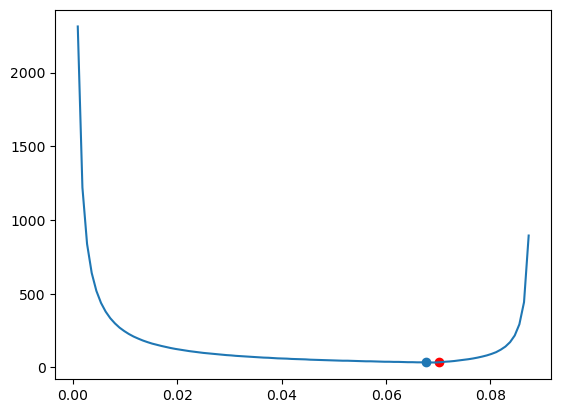

In [16]:
get_tao_plot(4)

Analytical solution tao_opt: 0.04248476460864264
Optimal iterations: 34
Experiment solution tao_opt: 0.04096565700105071
Optimal iterations: 31


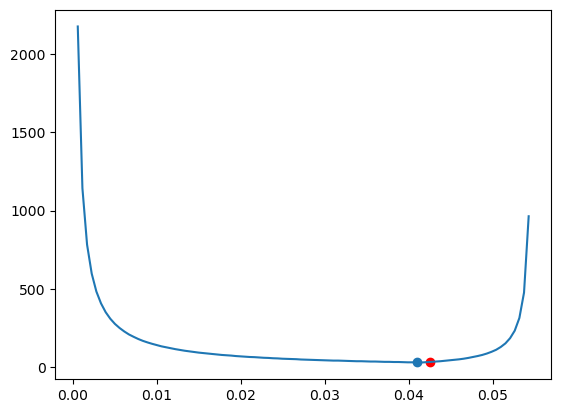

In [17]:
get_tao_plot(7)

Analytical solution tao_opt: 0.03196145311517127
Optimal iterations: 31
Experiment solution tao_opt: 0.030162614605431164
Optimal iterations: 27


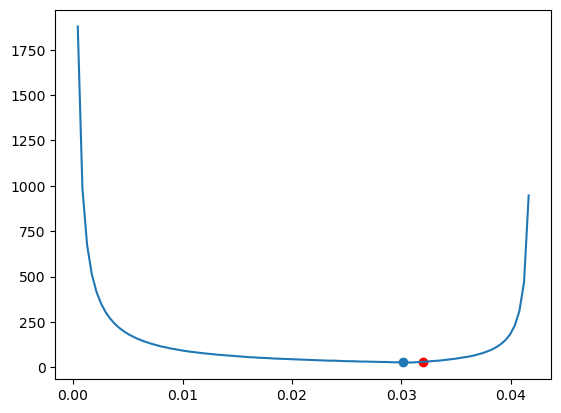

In [18]:
get_tao_plot(10)